# WLASL100 Dataset - UniSign Model Training

This notebook provides a complete pipeline for:
- 📂 **Loading preprocessed WLASL100 features** from feature directory
- 🚀 **Training UniSign model** (State-of-the-Art Transformer architecture)

## UniSign Model Architecture:
- **Spatial-Temporal Transformer** with multi-head attention
- **Feature sequences** (30 frames × 225 features) with positional encoding
- **Residual connections** and layer normalization
- **Classification head** with dropout regularization

## Data Format:
- Features are stored as `.npy` files in `train/`, `val/`, `test/` directories
- Each file contains a dict with `'data'` (shape: 30, 225) and `'label'`
- Uses the same data structure as the LSTM baseline model


## 1. Setup and Dependencies


In [1]:
# Install required packages
import subprocess
import sys
import os

print("Installing dependencies...")
print("="*60)

# Clear pip cache
try:
    subprocess.check_call([sys.executable, "-m", "pip", "cache", "purge"], 
                         stderr=subprocess.DEVNULL, stdout=subprocess.DEVNULL)
except:
    pass

# Update pip
subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "--quiet", 
                      "pip", "setuptools", "wheel"])

# Uninstall conflicting packages
packages_to_uninstall = ["numpy", "scipy", "scikit-learn", "pandas", 
                        "opencv-python", "opencv-python-headless", "mediapipe", "protobuf"]

for pkg in packages_to_uninstall:
    try:
        subprocess.run([sys.executable, "-m", "pip", "uninstall", "-y", "-q", pkg], 
                      capture_output=True, check=False)
    except:
        pass

# Install in correct order
print("Installing NumPy...")
subprocess.check_call([sys.executable, "-m", "pip", "install", "--no-cache-dir", 
                      "numpy==1.26.4"])

print("Installing other dependencies...")
packages = [
    "protobuf==4.25.3",
    "scikit-learn==1.3.2",
    "pandas",
    "opencv-python-headless==4.8.1.78",
    "mediapipe==0.10.21",
    "matplotlib",
    "seaborn",
    "tqdm",
    "tensorflow"
]

for package in packages:
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--no-cache-dir", package])
    except Exception as e:
        print(f"  ⚠️  Warning: {e}")

print("\n✅ Installation complete!")


Installing dependencies...
Installing NumPy...
Installing other dependencies...

✅ Installation complete!


In [9]:
# Import libraries
import os
import json
import zipfile
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from collections import Counter
import cv2
import mediapipe as mp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import warnings
warnings.filterwarnings('ignore')

# Define base directory for local Windows path
BASE_DIR = r"C:\Users\Nivedita\Documents\258\asl-hand-letter-detection-using-deep-learning"
# Path to preprocessed features (same structure as LSTM training)
FEATURES_ROOT = r"C:\Users\Nivedita\Documents\258\asl-hand-letter-detection-using-deep-learning\wlasl_100\wlasl100_features\wlasl100_features"

print(f"📁 Base directory: {BASE_DIR}")
print(f"📁 Features directory: {FEATURES_ROOT}")

print(f"TensorFlow: {tf.__version__}")
print(f"NumPy: {np.__version__}")

# GPU setup
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ Found {len(gpus)} GPU(s)")
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.keras.mixed_precision.set_global_policy('mixed_float16')
        print("✅ Mixed precision enabled")
    except RuntimeError as e:
        print(f"GPU config error: {e}")
else:
    print("⚠️  No GPU found, using CPU")


📁 Base directory: C:\Users\Nivedita\Documents\258\asl-hand-letter-detection-using-deep-learning
📁 Features directory: C:\Users\Nivedita\Documents\258\asl-hand-letter-detection-using-deep-learning\wlasl_100\wlasl100_features\wlasl100_features
TensorFlow: 2.19.0
NumPy: 1.26.4
⚠️  No GPU found, using CPU


## 2. Load Preprocessed Features


In [10]:
# Load label map
label_map_path = os.path.join(FEATURES_ROOT, "label_map.json")
if not os.path.exists(label_map_path):
    raise FileNotFoundError(f"label_map.json not found at {label_map_path}")

with open(label_map_path, 'r') as f:
    label_map = json.load(f)

NUM_CLASSES = len(label_map)
print(f"✅ Loaded label map: {NUM_CLASSES} classes")

# Create reverse mapping (index to word)
idx_to_word = {v: k for k, v in label_map.items()}
word_to_idx = label_map

print(f"   Sample classes: {list(label_map.keys())[:10]}")


✅ Loaded label map: 100 classes
   Sample classes: ['accident', 'africa', 'all', 'apple', 'basketball', 'bed', 'before', 'bird', 'birthday', 'black']


In [11]:
# Load features from .npy files (similar to LSTM training)
def load_features_from_directory(root_dir, split="train"):
    """Load features from .npy files in train/val/test directories."""
    split_dir = os.path.join(root_dir, split)
    
    if not os.path.exists(split_dir):
        raise FileNotFoundError(f"Directory not found: {split_dir}")
    
    files = []
    for root, _, filenames in os.walk(split_dir):
        for filename in filenames:
            if filename.endswith('.npy'):
                files.append(os.path.join(root, filename))
    
    if len(files) == 0:
        raise FileNotFoundError(f"No .npy files found in {split_dir}")
    
    print(f"📂 Loading {split} split from {split_dir}...")
    print(f"   Found {len(files)} feature files")
    
    sequences = []
    labels = []
    
    for file_path in tqdm(files, desc=f"Loading {split}"):
        try:
            # Load dictionary from .npy file
            data_dict = np.load(file_path, allow_pickle=True).item()
            
            # Extract features: shape (30, 225)
            features = data_dict['data'].astype(np.float32)
            
            # Extract label (integer index)
            label = int(data_dict['label'])
            
            sequences.append(features)
            labels.append(label)
        except Exception as e:
            print(f"⚠️  Error loading {file_path}: {e}")
            continue
    
    sequences = np.array(sequences, dtype=np.float32)
    labels = np.array(labels, dtype=np.int32)
    
    print(f"✅ Loaded {len(sequences)} samples")
    print(f"   Sequence shape: {sequences.shape}")
    print(f"   Labels shape: {labels.shape}")
    
    return sequences, labels

# Load train, val, and test splits
print("="*60)
print("Loading WLASL100 Features")
print("="*60)

X_train, y_train = load_features_from_directory(FEATURES_ROOT, "train")
X_val, y_val = load_features_from_directory(FEATURES_ROOT, "val")
X_test, y_test = load_features_from_directory(FEATURES_ROOT, "test")

print(f"\n📊 Dataset Summary:")
print(f"   Train: {X_train.shape[0]} samples")
print(f"   Val: {X_val.shape[0]} samples")
print(f"   Test: {X_test.shape[0]} samples")
print(f"   Sequence length: {X_train.shape[1]} frames")
print(f"   Feature dimension: {X_train.shape[2]} features")
print(f"   Classes: {NUM_CLASSES}")


Loading WLASL100 Features
📂 Loading train split from C:\Users\Nivedita\Documents\258\asl-hand-letter-detection-using-deep-learning\wlasl_100\wlasl100_features\wlasl100_features\train...
   Found 1001 feature files


Loading train:  12%|█▏        | 124/1001 [00:00<00:00, 1227.76it/s]

Loading train: 100%|██████████| 1001/1001 [00:00<00:00, 1564.07it/s]


✅ Loaded 1001 samples
   Sequence shape: (1001, 32, 225)
   Labels shape: (1001,)
📂 Loading val split from C:\Users\Nivedita\Documents\258\asl-hand-letter-detection-using-deep-learning\wlasl_100\wlasl100_features\wlasl100_features\val...
   Found 242 feature files


Loading val: 100%|██████████| 242/242 [00:00<00:00, 1503.09it/s]


✅ Loaded 242 samples
   Sequence shape: (242, 32, 225)
   Labels shape: (242,)
📂 Loading test split from C:\Users\Nivedita\Documents\258\asl-hand-letter-detection-using-deep-learning\wlasl_100\wlasl100_features\wlasl100_features\test...
   Found 200 feature files


Loading test: 100%|██████████| 200/200 [00:00<00:00, 1515.18it/s]

✅ Loaded 200 samples
   Sequence shape: (200, 32, 225)
   Labels shape: (200,)

📊 Dataset Summary:
   Train: 1001 samples
   Val: 242 samples
   Test: 200 samples
   Sequence length: 32 frames
   Feature dimension: 225 features
   Classes: 100


In [12]:
# Note: Features are already normalized in preprocessing (body-relative normalization)
# The preprocessing normalizes landmarks relative to body shoulders, which is crucial for ASL.
# Additional per-sequence normalization might be redundant, but we can optionally apply
# a light standardization for numerical stability.

print("🔧 Applying light standardization (preprocessing already did body-relative normalization)...")

# Optional: Light standardization for numerical stability (subtle, doesn't change relative positions)
# This is different from the body-relative normalization done in preprocessing
def light_standardize(sequences):
    """Apply light standardization for numerical stability."""
    # Use global statistics across all sequences for consistency
    global_mean = np.mean(sequences)
    global_std = np.std(sequences) + 1e-8
    return (sequences - global_mean) / global_std

# Apply light standardization (optional - can be skipped if preprocessing normalization is sufficient)
X_train = light_standardize(X_train)
X_val = light_standardize(X_val)
X_test = light_standardize(X_test)

print("✅ Light standardization complete")
print("   Note: Preprocessing already normalized landmarks relative to body (shoulders)")
print("   This is important for ASL as hand position relative to body matters!")


🔧 Applying light standardization (preprocessing already did body-relative normalization)...
✅ Light standardization complete
   Note: Preprocessing already normalized landmarks relative to body (shoulders)
   This is important for ASL as hand position relative to body matters!


## 3. Build UniSign Model Architecture


In [13]:
# Model configuration based on feature dimensions
SEQUENCE_LENGTH = X_train.shape[1]  # 30 frames
FEATURE_DIM = X_train.shape[2]       # 225 features

print(f"📐 Model Configuration:")
print(f"   Sequence length: {SEQUENCE_LENGTH}")
print(f"   Feature dimension: {FEATURE_DIM}")
print(f"   Number of classes: {NUM_CLASSES}")

def build_unisign_model(
    sequence_length=SEQUENCE_LENGTH,
    feature_dim=FEATURE_DIM,
    num_classes=NUM_CLASSES,
    d_model=256,
    num_heads=8,
    num_layers=4,
    dff=512,
    dropout_rate=0.1,
    max_dropout=0.3
):
    """
    Build UniSign Transformer model for WLASL100 recognition.
    
    Architecture (similar to reference LSTM but with Transformer):
    - Input: Sequence of features (T=30, D=225)
    - Embedding: Linear projection + positional encoding
    - Transformer blocks: Multi-head attention + FFN with residual connections
    - Classification head: Global pooling + dense layers
    
    This is similar to the LSTM baseline but uses Transformer architecture.
    """
    
    inputs = layers.Input(shape=(sequence_length, feature_dim), name='feature_sequence')
    
    # Input embedding with positional encoding
    x = layers.Dense(d_model, name='input_projection')(inputs)  # (T, d_model)
    
    # Positional encoding (learnable)
    positions = tf.range(start=0, limit=sequence_length, delta=1)
    pos_encoding = layers.Embedding(sequence_length, d_model, name='pos_encoding')(positions)
    x = x + pos_encoding
    x = layers.LayerNormalization(name='pre_norm')(x)
    
    # Transformer encoder blocks
    for i in range(num_layers):
        # Multi-head self-attention
        attn_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=d_model // num_heads,
            dropout=dropout_rate,
            name=f'transformer_block_{i}_attn'
        )(x, x)
        attn_output = layers.Dropout(dropout_rate, name=f'transformer_block_{i}_attn_dropout')(attn_output)
        x = layers.Add(name=f'transformer_block_{i}_add1')([x, attn_output])
        x = layers.LayerNormalization(name=f'transformer_block_{i}_norm1')(x)
        
        # Feed-forward network
        ffn_output = layers.Dense(dff, activation='gelu', name=f'transformer_block_{i}_ffn1')(x)
        ffn_output = layers.Dropout(dropout_rate, name=f'transformer_block_{i}_ffn_dropout')(ffn_output)
        ffn_output = layers.Dense(d_model, name=f'transformer_block_{i}_ffn2')(ffn_output)
        x = layers.Add(name=f'transformer_block_{i}_add2')([x, ffn_output])
        x = layers.LayerNormalization(name=f'transformer_block_{i}_norm2')(x)
    
    # Global temporal pooling (similar to LSTM's mean pooling)
    pooled = layers.GlobalAveragePooling1D(name='temporal_pooling')(x)
    
    # Classification head
    x = layers.Dense(512, activation='gelu', name='classifier_dense1')(pooled)
    x = layers.BatchNormalization(name='classifier_bn1')(x)
    x = layers.Dropout(max_dropout, name='classifier_dropout1')(x)
    
    x = layers.Dense(256, activation='gelu', name='classifier_dense2')(x)
    x = layers.BatchNormalization(name='classifier_bn2')(x)
    x = layers.Dropout(max_dropout * 0.7, name='classifier_dropout2')(x)
    
    outputs = layers.Dense(num_classes, activation='softmax', dtype='float32', name='predictions')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name='UniSign_WLASL100')
    return model

# Build model
print("\n🔨 Building UniSign model...")
model = build_unisign_model(
    sequence_length=SEQUENCE_LENGTH,
    feature_dim=FEATURE_DIM,
    num_classes=NUM_CLASSES
)

print("\n📐 Model Architecture:")
print("="*60)
model.summary()

total_params = model.count_params()
print(f"\n📊 Total Parameters: {total_params:,}")


📐 Model Configuration:
   Sequence length: 32
   Feature dimension: 225
   Number of classes: 100

🔨 Building UniSign model...

📐 Model Architecture:


Model: "UniSign_WLASL100"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ feature_sequence    │ (None, 32, 225)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_projection    │ (None, 32, 256)   │     57,856 │ feature_sequence… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 32, 256)   │          0 │ input_projection… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pre_norm            │ (None, 32, 256)   │        512 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_… │ (None, 32, 256)   │    263,168 │ pre_norm[0][0],   │
│ (MultiHeadAttentio… │                   │            │ pre_norm[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_… │ (None, 32, 256)   │          0 │ transformer_bloc… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_… │ (None, 32, 256)   │          0 │ pre_norm[0][0],   │
│ (Add)               │                   │            │ transformer_bloc… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_… │ (None, 32, 256)   │        512 │ transformer_bloc… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_… │ (None, 32, 512)   │    131,584 │ transformer_bloc… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_… │ (None, 32, 512)   │          0 │ transformer_bloc… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_… │ (None, 32, 256)   │    131,328 │ transformer_bloc… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_… │ (None, 32, 256)   │          0 │ transformer_bloc… │
│ (Add)               │                   │            │ transformer_bloc… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_… │ (None, 32, 256)   │        512 │ transformer_bloc… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_… │ (None, 32, 256)   │    263,168 │ transformer_bloc… │
│ (MultiHeadAttentio… │                   │            │ transformer_bloc… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_… │ (None, 32, 256)   │          0 │ transformer_bloc… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_… │ (None, 32, 256)   │          0 │ transformer_bloc… │
│ (Add)               │                   │            │ transformer_bloc… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_… │ (None, 32, 256)   │        512 │ transformer_bloc… │
│ (LayerNormalizatio… │                   │            │                 

 Total params: 2,458,468 (9.38 MB)

 Trainable params: 2,456,932 (9.37 MB)

 Non-trainable params: 1,536 (6.00 KB)


📊 Total Parameters: 2,458,468


## 4. Training Configuration


In [14]:
# Training configuration (similar to LSTM training)
BATCH_SIZE = 32
EPOCHS = 80
LEARNING_RATE = 2e-4
WEIGHT_DECAY = 1e-4

# Optimizer with ReduceLROnPlateau callback (similar to LSTM training)
optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

# Compile model
# Note: Use SparseTopKCategoricalAccuracy since we're using sparse (integer) labels
# TopKCategoricalAccuracy expects one-hot encoded labels
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top5_accuracy'),
        keras.metrics.SparseTopKCategoricalAccuracy(k=10, name='top10_accuracy')
    ]
)

print("✅ Model compiled and ready for training")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Learning rate: {LEARNING_RATE}")
print(f"   Epochs: {EPOCHS}")
print(f"   Weight decay: {WEIGHT_DECAY}")


✅ Model compiled and ready for training
   Batch size: 32
   Learning rate: 0.0002
   Epochs: 80
   Weight decay: 0.0001


## 5. Train UniSign Model


In [15]:
# Callbacks
model_path = os.path.join(BASE_DIR, 'unisign_wlasl100_model.keras')
callbacks_list = [
    callbacks.ModelCheckpoint(
        model_path,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

# Train model
print("🚀 Starting training...")
print(f"   Training samples: {len(X_train)}")
print(f"   Validation samples: {len(X_val)}")
print(f"   Classes: {NUM_CLASSES}")
print("="*60)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks_list,
    verbose=1
)

print("\n✅ Training complete!")


🚀 Starting training...
   Training samples: 1001
   Validation samples: 242
   Classes: 100
Epoch 1/80
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.0145 - loss: 5.2662 - top10_accuracy: 0.1123 - top5_accuracy: 0.0654
Epoch 1: val_accuracy improved from -inf to 0.00413, saving model to C:\Users\Nivedita\Documents\258\asl-hand-letter-detection-using-deep-learning\unisign_wlasl100_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 36s 477ms/step - accuracy: 0.0145 - loss: 5.2632 - top10_accuracy: 0.1125 - top5_accuracy: 0.0652 - val_accuracy: 0.0041 - val_loss: 4.5637 - val_top10_accuracy: 0.1446 - val_top5_accuracy: 0.0620 - learning_rate: 2.0000e-04
Epoch 2/80
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.0266 - loss: 4.7282 - top10_accuracy: 0.2334 - top5_accuracy: 0.1262
Epoch 2: val_accuracy improved from 0.00413 to 0.01653, saving model to C:\Users\Nivedita\Documents\258\asl-hand-letter-detection-using-deep-learning\unisign_wlasl100_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 

## 6. Evaluate Model


In [16]:
# Evaluate on test set
print("📊 Evaluating on test set...")
print("="*60)

results = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy (Top-1): {results[1]:.4f} ({results[1]*100:.2f}%)")
print(f"Test Top-5 Accuracy: {results[2]:.4f} ({results[2]*100:.2f}%)")
print(f"Test Top-10 Accuracy: {results[3]:.4f} ({results[3]*100:.2f}%)")

# Generate predictions for detailed analysis
predictions = model.predict(X_test, verbose=0)
y_pred = np.argmax(predictions, axis=1)

# Top-5 and Top-10 accuracy calculation
top5_correct = 0
top10_correct = 0
for i in range(len(y_test)):
    top5_preds = np.argsort(predictions[i])[-5:][::-1]
    top10_preds = np.argsort(predictions[i])[-10:][::-1]
    if y_test[i] in top5_preds:
        top5_correct += 1
    if y_test[i] in top10_preds:
        top10_correct += 1

print(f"\n>>> FINAL TEST RESULTS <<<")
print(f"Top-1 Accuracy: {results[1]*100:.2f}%")
print(f"Top-5 Accuracy: {top5_correct/len(y_test)*100:.2f}%")
print(f"Top-10 Accuracy: {top10_correct/len(y_test)*100:.2f}%")


📊 Evaluating on test set...
Test Loss: 2.4931
Test Accuracy (Top-1): 0.4350 (43.50%)
Test Top-5 Accuracy: 0.7500 (75.00%)
Test Top-10 Accuracy: 0.8300 (83.00%)

>>> FINAL TEST RESULTS <<<
Top-1 Accuracy: 43.50%
Top-5 Accuracy: 75.00%
Top-10 Accuracy: 83.00%


In [21]:
# Classification report
from sklearn.metrics import classification_report, confusion_matrix

print("\n📈 Classification Report:")
print("="*60)

# Get unique classes present in test set (both true and predicted)
unique_classes = np.unique(np.concatenate([y_test, y_pred]))
unique_classes = np.sort(unique_classes)

# Create class names only for classes present in test set
class_names = [idx_to_word[i] for i in unique_classes]

# Print classification report with only classes present in test set
print(classification_report(y_test, y_pred, labels=unique_classes, 
                          target_names=class_names, 
                          zero_division=0, output_dict=False))

# Print summary of missing classes (if any)
all_classes = set(range(NUM_CLASSES))
test_classes = set(unique_classes)
missing_classes = all_classes - test_classes
if missing_classes:
    print(f"\n⚠️  Note: {len(missing_classes)} class(es) not present in test set:")
    for cls_idx in sorted(missing_classes):
        print(f"   - {idx_to_word[cls_idx]} (class {cls_idx})")
else:
    print(f"\n✅ All {NUM_CLASSES} classes are present in test set")

# Save model and label map
final_model_path = os.path.join(BASE_DIR, 'unisign_wlasl100_final.keras')
label_map_path_save = os.path.join(BASE_DIR, 'wlasl100_label_map.json')

model.save(final_model_path)
with open(label_map_path_save, 'w') as f:
    json.dump(label_map, f, indent=2)

print("\n✅ Model and label map saved!")
print(f"   Model: {final_model_path}")
print(f"   Label map: {label_map_path_save}")



📈 Classification Report:
              precision    recall  f1-score   support

    accident       1.00      0.33      0.50         3
      africa       1.00      1.00      1.00         2
         all       1.00      0.50      0.67         2
       apple       0.50      1.00      0.67         1
  basketball       0.50      0.50      0.50         2
         bed       1.00      1.00      1.00         2
      before       0.67      0.67      0.67         3
        bird       0.00      0.00      0.00         2
    birthday       0.25      0.50      0.33         2
       black       1.00      0.33      0.50         3
        blue       0.50      0.50      0.50         2
        book       0.00      0.00      0.00         0
     bowling       0.00      0.00      0.00         2
       brown       1.00      0.50      0.67         2
         but       0.00      0.00      0.00         2
         can       0.50      1.00      0.67         1
       candy       0.17      0.33      0.22         3
 

## 7. Training History Visualization


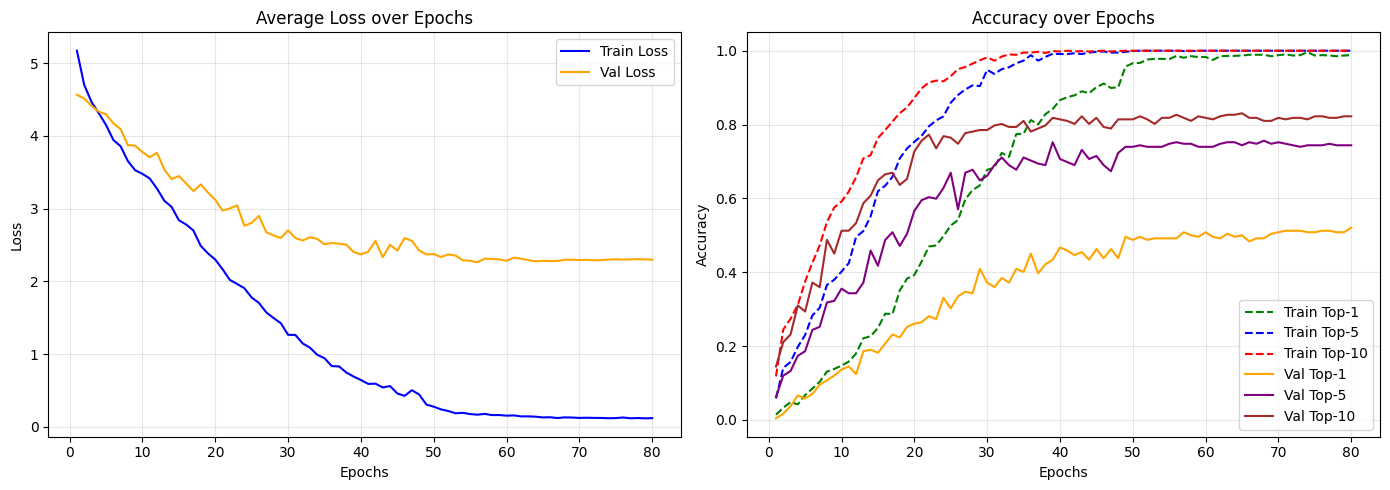

In [18]:
# Plot training history (similar to LSTM training visualization)
def plot_training_history(history):
    epochs = range(1, len(history.history['loss']) + 1)
    
    plt.figure(figsize=(14, 5))
    
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], label='Train Loss', color='blue')
    plt.plot(epochs, history.history['val_loss'], label='Val Loss', color='orange')
    plt.title('Average Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Accuracy (Top-1, Top-5, Top-10)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], label='Train Top-1', color='green', linestyle='--')
    if 'top5_accuracy' in history.history:
        plt.plot(epochs, history.history['top5_accuracy'], label='Train Top-5', color='blue', linestyle='--')
    if 'top10_accuracy' in history.history:
        plt.plot(epochs, history.history['top10_accuracy'], label='Train Top-10', color='red', linestyle='--')
    
    plt.plot(epochs, history.history['val_accuracy'], label='Val Top-1', color='orange')
    if 'val_top5_accuracy' in history.history:
        plt.plot(epochs, history.history['val_top5_accuracy'], label='Val Top-5', color='purple')
    if 'val_top10_accuracy' in history.history:
        plt.plot(epochs, history.history['val_top10_accuracy'], label='Val Top-10', color='brown')
    
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)


## 8. Confusion Matrix Visualization


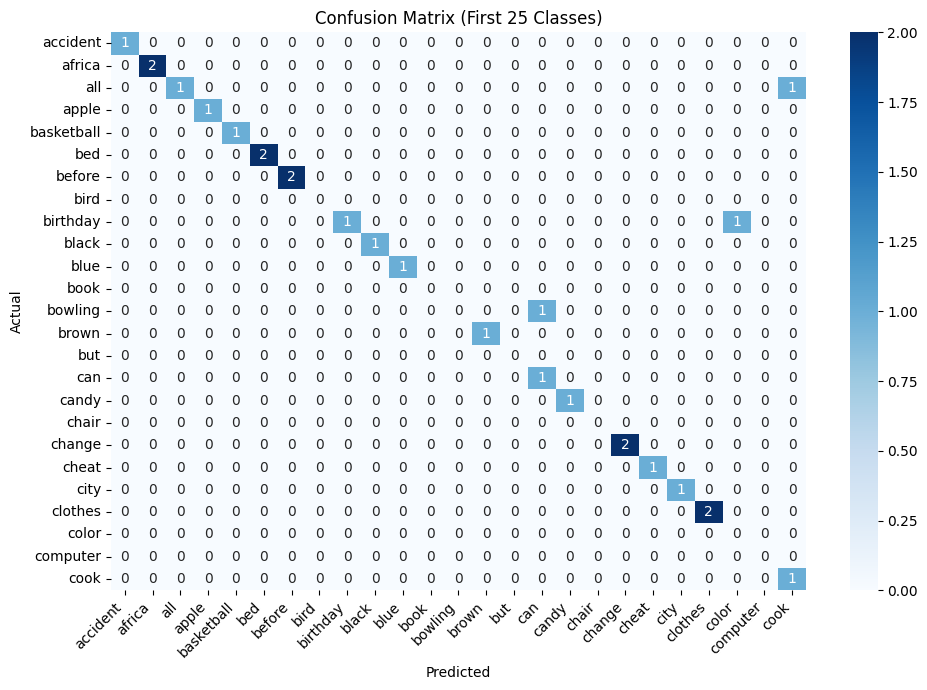

In [19]:
# Plot confusion matrix (similar to LSTM training)
def plot_confusion_matrix(y_true, y_pred, idx_to_word, limit=25):
    """Plot confusion matrix for first N classes."""
    mask = (y_true < limit) & (y_pred < limit)
    y_true_sub = y_true[mask]
    y_pred_sub = y_pred[mask]
    
    if len(y_true_sub) == 0:
        print(f"Not enough data in the first {limit} classes to plot a matrix.")
        return
    
    class_names = [idx_to_word[i] for i in range(limit)]
    cm = confusion_matrix(y_true_sub, y_pred_sub, labels=range(limit))
    
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix (First {limit} Classes)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_test, y_pred, idx_to_word, limit=25)


## Summary

✅ **Completed:**
1. Loaded preprocessed WLASL100 features from feature directory
2. Built and trained UniSign Transformer model
3. Evaluated model performance with Top-1, Top-5, Top-10 accuracy
4. Visualized training history and confusion matrix

📁 **Output Files:**
- `unisign_wlasl100_final.keras` - Trained UniSign model
- `wlasl100_label_map.json` - Label mapping

💡 **Comparison with LSTM Baseline:**
- **LSTM**: Uses bidirectional LSTM with mean pooling
- **UniSign**: Uses Transformer with multi-head attention
- Both use the same feature format (30 frames × 225 features)
- Both train on the same train/val/test splits
